In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matchPics import matchPics
from helper import plotMatches
from planarH import computeH_ransac, compositeH

In [2]:
cv_cover = cv2.imread('../data/cv_cover.jpg')
cv_desk = cv2.imread('../data/cv_desk.png')

## OpenCV ORB

In [28]:
# Load images
# Detect keypoints and extract descriptors
orb = cv2.ORB_create(nfeatures=10000)

kp1, des1 = orb.detectAndCompute(cv_cover, None)
kp2, des2 = orb.detectAndCompute(cv_desk, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches_cv = bf.match(des1, des2)

# Sort matches by distance
matches_cv = sorted(matches_cv, key=lambda x: x.distance)

# Select the top 10% accurate matches

num_matches = int(len(matches_cv) * 0.1)  # choose 10% of total matches
best_matches = matches_cv[:num_matches]

pts1_best = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1, 2)
pts2_best = np.float32([kp2[m.trainIdx].pt for m in best_matches]).reshape(-1, 2)


### 내코드

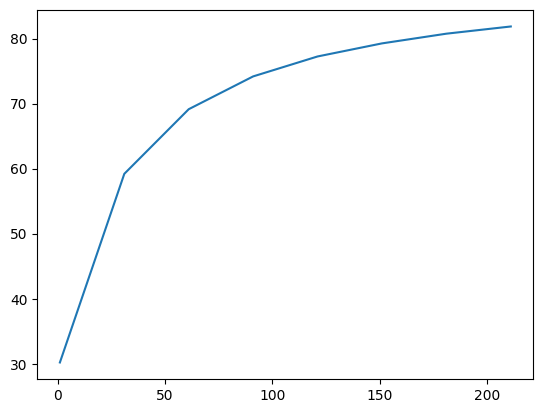

In [29]:
# number of iteration
ransac = np.array([])
inlier_sample = np.array([])
iter_arr = np.array([])

for iter in range(1, 240, 30):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best, pts1_best, iter)
        
        num_inliers = np.sum(inliers)

        inlier_sample = np.append(inlier_sample, np.array([num_inliers]), axis=0)

    #print(inlier_sample)
    inlier_avg = np.mean(inlier_sample)
    #print(inlier_avg)
    ransac = np.append(ransac, [inlier_avg], axis=0)
    iter_arr = np.append(iter_arr, [iter], axis=0)

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()


locs1 = pts2_best
locs2 = pts1_best

n = locs1.shape[0]

### threshold 4, 3000번

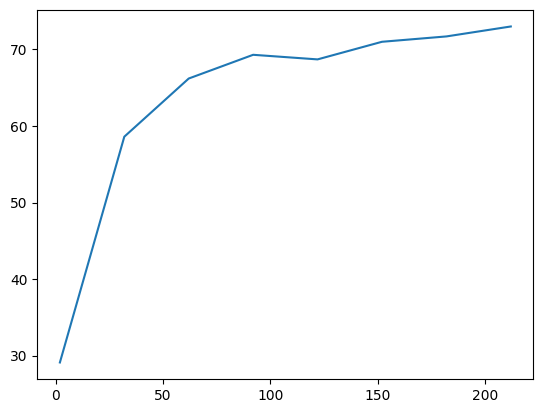

In [33]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 240, 30)
ransac = np.zeros((len(iter_arr),))

for iter_idx, iter in enumerate(iter_arr):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best, pts1_best, iter, inlier_tol = 2, adaptive = True)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac[iter_idx] = inlier_avg

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.show()

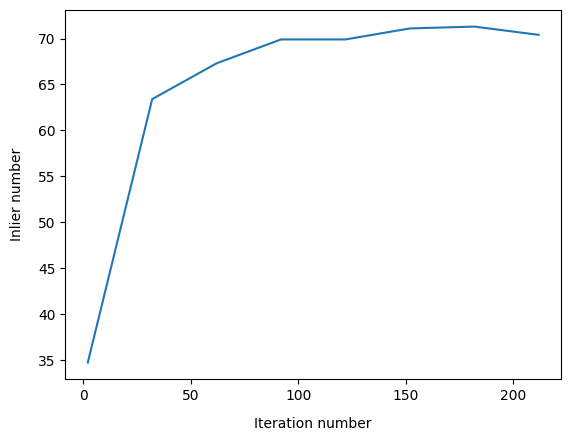

In [32]:
inlier_sample = np.zeros((10,))
iter_arr = np.arange(2, 240, 30)
ransac = []

for iter in range(2, 240, 30):
    for i in range(10):
        H2to1, inliers = computeH_ransac(pts2_best, pts1_best, iter, inlier_tol = 2, adaptive = True)
        num_inliers = np.sum(inliers)
        inlier_sample[i] = num_inliers

    inlier_avg = np.mean(inlier_sample)
    ransac.append(inlier_avg)

# visualize the number of inliers for it
plt.plot(iter_arr, ransac)
plt.xlabel('Iteration number', labelpad=10)
plt.ylabel('Inlier number', labelpad=10)
plt.show()
plt.show()

### Experiments

### Visualization

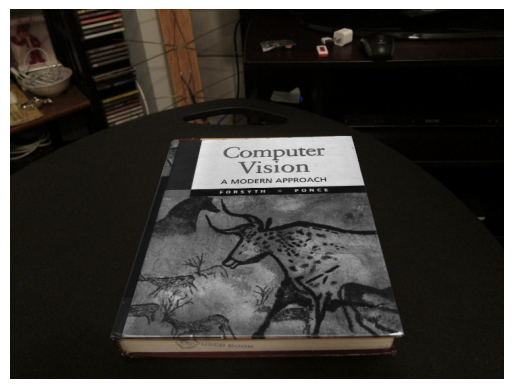

In [34]:
h, w = cv_desk.shape[:2]

result = compositeH(H2to1, cv_cover, cv_desk)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)
plt.axis('off')
plt.show()

### TEST

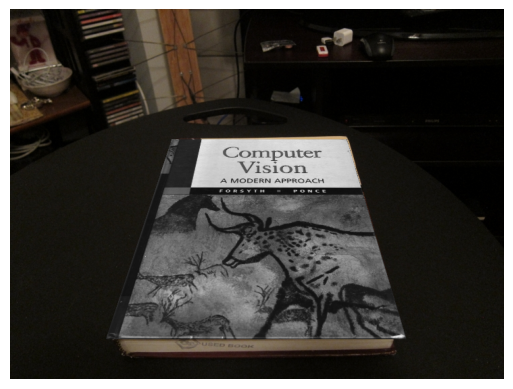

In [37]:
# Compute homography matrix
H2to1_aptvie, inliers = computeH_ransac(pts2_best, pts1_best, 200, adaptive = True)

h, w = cv_desk.shape[:2]

result = compositeH(H2to1_aptvie, cv_cover, cv_desk)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

plt.imshow(result)
plt.axis('off')
plt.show()